In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential

In [2]:
df_1=pd.read_csv('dc_part.csv')
df_2=pd.read_csv('chenqin5%.csv')
df_4=pd.read_csv('yunDataN.csv')
print(df_1.shape,df_2.shape,df_4.shape)

(124293, 147) (124293, 92) (124293, 74)


# Mergeing the 4 parts of the datasets with the zero-rate less than 95%

In [3]:
data_parts=[df_1,df_2,df_4]
useful=[] # the column names for each parts that have less than 95% zeros
for ele in data_parts:
  useful_sub=[]
  for col in ele.columns:
    if ele[col].isin([0]).sum()/ele.shape[0]<0.95:
      useful_sub.append(col)
  useful.append(useful_sub)
useful[2]=useful[2][1:]  # drop unuseful column_name in the 4th part

In [4]:
df_1=df_1.loc[:,useful[0]]
df_2=df_2.loc[:,useful[1]]
df_4=df_4.loc[:,useful[2]]

In [5]:
result = pd.concat([df_1,df_2,df_4], axis=1, sort=False) # combine the dateset

In [6]:
result.head()

,_key_client_id,_key_occurreddate_month,Total_incident_count,response_variable,incident_subcatgry_unknown_piv,prgcontct_other_organisation_piv,prgcontct_lwb_worker_piv,prgcontct_both_client_and_carer_piv,prgcontct_department_piv,prgcontct_family_piv,prgcontct_carer_piv,prgcontct_client_piv,prgcontct_meeting_group_of_people_piv_sum_n_days,prgcontct_other_organisation_piv_sum_n_days,prgcontct_educational_institution_piv_sum_n_days,prgcontct_lwb_worker_piv_sum_n_days,prgcontct_both_client_and_carer_piv_sum_n_days,prgcontct_health_professional_piv_sum_n_days,prgcontct_department_piv_sum_n_days,prgcontct_other_stakeholder_piv_sum_n_days,prgcontct_family_piv_sum_n_days,prgcontct_carer_piv_sum_n_days,prgcontct_client_piv_sum_n_days,prgcontct_meeting_group_of_people_piv_days_since,prgcontct_other_organisation_piv_days_since,prgcontct_meeting_lwb_internal_only_piv_days_since,prgcontct_educational_institution_piv_days_since,prgcontct_employer_piv_days_since,prgcontct_lwb_worker_piv_days_since,prgcontct_police_piv_days_since,prgcontct_both_client_and_carer_piv_days_since,prgcontct_health_professional_piv_days_since,prgcontct_department_piv_days_since,prgcontct_other_stakeholder_piv_days_since,prgcontct_family_piv_days_since,prgcontct_carer_piv_days_since,prgcontct_client_piv_days_since,progsubjcat_information_provided_piv,progsubjcat_case_discussion_planning_piv,progsubjcat_i_sight_client_incident_system_generated_piv,...,rowtype_reference_piv_avg_n_days,rowtype_client_address_addition_piv_days_since,rowtype_rp_end_piv_days_since,rowtype_rp_start_piv_days_since,rowtype_progress_note_piv_days_since,rowtype_diagnosis_piv_days_since,rowtype_medictn_start_piv_days_since,rowtype_client_plan_start_piv_days_since,rowtype_client_plan_end_piv_days_since,rowtype_keyworker_change_piv_days_since,rowtype_reference_piv_days_since,rowtype_medictn_end_piv_days_since,rowtype_plcment_end_piv_days_since,rowtype_incident_piv_days_since,rowtype_plcment_start_piv_days_since,rowtype_program_primary_service_type_start_piv_days_since,rowtype_client_alert_start_piv_days_since,rowtype_client_address_addition_piv_lag01,rowtype_rp_end_piv_lag01,rowtype_rp_start_piv_lag01,rowtype_progress_note_piv_lag01,rowtype_diagnosis_piv_lag01,rowtype_medictn_start_piv_lag01,rowtype_client_plan_start_piv_lag01,rowtype_client_plan_end_piv_lag01,rowtype_keyworker_change_piv_lag01,rowtype_reference_piv_lag01,rowtype_medictn_end_piv_lag01,rowtype_plcment_end_piv_lag01,rowtype_incident_piv_lag01,rowtype_plcment_start_piv_lag01,rowtype_program_primary_service_type_start_piv_lag01,rowtype_client_alert_start_piv_lag01,status_placement,status_client_plan,status_rp_mechanical_restraint,status_rp_restricted_access,status_rp_chemical_restraint,status_rp_other,Incident
0,0000D172-EA88-432F-8235-9FAA00D29072,2019-04-01T00:00:00.0,0,0,29,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,2868,3650,3650,0,1,0,...,1,603,355,376,890,515,492,761,555,345,2,425,469,703,527,577,488,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,1,2,2,2,0
1,0000D172-EA88-432F-8235-9FAA00D29072,2019-05-01T00:00:00.0,0,0,31,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,22,3650,3650,0,0,0,...,1,603,355,376,21,515,492,761,555,345,0,425,469,703,527,577,488,1,1,1,2,1,1,1,1,1,38,1,1,1,1,1,1,2,2,1,2,2,2,0
2,0000D172-EA88-432F-8235-9FAA00D29072,2019-06-01T00:00:00.0,0,0,31,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,52,3650,3650,0,0,0,...,1,559,355,376,51,515,492,761,555,345,0,425,469,703,527,577,488,1,1,1,1,1,1,1,1,1,46,1,1,1,1,1,1,2,2,1,2,2,2,0
3,0000D172-EA88-432F-8235-9FAA00D29072,2019-07-01T00:00:00.0,0,0,32,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,83,3650,483,0,1,0,...,1,21,355,376,20,515,492,761,555,345,0,425,469,703,527,577,488,3,1,1,1,1,1,1,1,1,40,1,1,1,1,1,1,2,2,1

### Parse 'Dates' and indexs it

In [7]:
result.to_csv('Dataconcate.csv')

In [8]:
Dataset=pd.read_csv('Dataconcate.csv',parse_dates=['_key_occurreddate_month'],index_col=['_key_client_id','_key_occurreddate_month'])

In [9]:
Dataset.drop(['Unnamed: 0','response_variable'],axis=1).head()

Total_incident_count  ...  Incident
_key_client_id                       _key_occurreddate_month                        ...          
0000D172-EA88-432F-8235-9FAA00D29072 2019-04-01                                  0  ...         0
                                     2019-05-01                                  0  ...         0
                                     2019-06-01                                  0  ...         0
                                     2019-07-01                                  0  ...         0
                                     2019-08-01                                  0  ...         0

[5 rows x 150 columns]

In [10]:
client_id=list(Dataset.index.get_level_values(0)) # the value of '_key_client_id' indexe

### Remove the Useless records

In [11]:
from collections import Counter
occurrences = Counter(client_id)

In [12]:
used_id=[]
usedless_id=[]
for key, value in occurrences.items():
  if value==12:  # number can be changed
    used_id.append(key)
  else:
    usedless_id.append(key)

In [13]:
print(f'Useful client:  {len(used_id):d}\nUseless client: {len(usedless_id):d}')

Useful client:  7380
Useless client: 7007


In [14]:
# remove the rows that the record of client is less than 12 month 
Dataset=Dataset.drop(usedless_id,level=0) 
Dataset.shape

(88560, 152)

In [15]:
Dataset.drop(['Unnamed: 0','response_variable'],axis=1,inplace=True)

## Perparing Dateset for Modelling

### Spliting to Train and Test Set

In [16]:
split=int(0.9*len(used_id))
train_index=used_id[:split] # the clients who will in trainset
test_index=used_id[split:] # the clients who will in testset

# Train dataset
train=Dataset.loc[train_index]
train_x = train.drop('Incident',axis=1)
train_y = train.Incident

# Test Dataset
test=Dataset.loc[test_index]
test_x = test.drop('Incident',axis=1)
test_y = test.Incident

print(train.shape,test.shape)

(79704, 150) (8856, 150)


### Normalize the Data

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

train_x = scaler.fit_transform(train_x)

test_x = scaler.transform(test_x)

###Serializing the Dataset

In [41]:
# 4D output
import numpy as np

def create_dataset(X, y, time_steps,window, number):
  xs, ys,channel = [],[],0
  while channel < number: # ensure all client data change to time series type
    xs_sub, ys_sub =[],[]
    for i in range(window - time_steps):
      shifft= window * channel
      v = X[i+shifft:(i + shifft + time_steps)]
      xs_sub.append(v)
      ys_sub.append(y[i + shifft + time_steps])

    channel+=1
    xs.append(xs_sub)
    ys.append(ys_sub)

  return np.array(xs),np.array(ys)

In [42]:
TIME_STEPS = 4
WINDOW = 12
NUM_TRAIN = len(train_index)
NUM_TEST = len(test_index)

X_train, y_train = create_dataset(train_x,train_y, TIME_STEPS, WINDOW, NUM_TRAIN)
X_test, y_test = create_dataset(test_x, test_y, TIME_STEPS, WINDOW,NUM_TEST)

In [43]:
# [n_samples, (n_sub_sequence),TIME_STEPS, n_features], [n_samples]
print(X_train.shape, y_train.shape)

(6642, 8, 4, 149) (6642, 8)


## LSTM AutoEncoder

In [39]:
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
''' 4D input [n_samples, n_sub_sequence,TIME_STEPS, n_features]'''
def ConvLSMT_autoencoder(X):
  model = Sequential()
  model.add(layers.TimeDistributed(layers.Conv1D(filters=16, kernel_size=1, activation='relu'), input_shape=(None, X.shape[2], X.shape[3])))
  model.add(layers.TimeDistributed(layers.MaxPooling1D(pool_size=2)))
  model.add(layers.TimeDistributed(layers.Flatten()))
  model.add(layers.LSTM(32, activation='relu'))
  model.add(layers.RepeatVector(X.shape[2]))
  model.add(layers.LSTM(4, activation='relu', return_sequences=True))
  model.add(layers.Flatten())
  model.add(layers.Dense(8,activation='sigmoid'))
  return model

In [44]:
model = ConvLSMT_autoencoder(X_train)
#model= LSTM_autoencoder(X_train)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 4, 16)       2400      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 2, 16)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 32)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                8320      
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 4, 32)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 4, 4)              592       
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)               

In [218]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [219]:
history = model.fit(
    X_train,y_train,
    epochs=150,
    batch_size=48,
    validation_split=0.1,shuffle=False)

Epoch 1/150
125/125 [==============================] - 2s 14ms/step - loss: 0.0533 - accuracy: 0.2234 - val_loss: 0.1600 - val_accuracy: 0.2165
Epoch 2/150
125/125 [==============================] - 1s 11ms/step - loss: 0.0527 - accuracy: 0.2247 - val_loss: 0.1634 - val_accuracy: 0.2105
Epoch 3/150
125/125 [==============================] - 1s 10ms/step - loss: 0.0523 - accuracy: 0.2242 - val_loss: 0.1626 - val_accuracy: 0.2150
Epoch 4/150
125/125 [==============================] - 1s 10ms/step - loss: 0.0520 - accuracy: 0.2240 - val_loss: 0.1653 - val_accuracy: 0.2150
Epoch 5/150
125/125 [==============================] - 1s 10ms/step - loss: 0.0518 - accuracy: 0.2244 - val_loss: 0.1628 - val_accuracy: 0.2180
Epoch 6/150
125/125 [==============================] - 1s 11ms/step - loss: 0.0524 - accuracy: 0.2242 - val_loss: 0.1659 - val_accuracy: 0.2120
Epoch 7/150
125/125 [==============================] - 1s 10ms/step - loss: 0.0530 - accuracy: 0.2240 - val_loss: 0.1686 - val_accuracy:

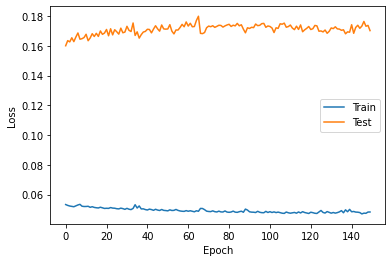

In [223]:
import matplotlib.pyplot as plt
plt.plot(history.epoch, history.history['loss'], label='Train')
plt.plot(history.epoch, history.history['val_loss'], label='Test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Find the threshold for dividing positive samples and neigative samples

In [145]:
predict = model.predict(X_test)
predict.shape

(738, 8)

In [146]:
predict[1]

array([3.0160449e-12, 5.0414354e-08, 2.5601383e-12, 1.7278914e-11,
       1.8369944e-07, 5.3930305e-09, 2.3618042e-03, 2.2391498e-02],
      dtype=float32)

In [147]:
predict[0]

array([4.3665634e-11, 3.7971497e-09, 1.9269036e-15, 8.9610203e-12,
       2.2153342e-06, 2.8727476e-12, 2.6892003e-05, 1.2616992e-02],
      dtype=float32)

In [148]:
month=['May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
Client=used_id[-y_test.shape[0]:]

preidct_df = pd.DataFrame(predict,columns=month,index=Client,)
True_df=pd.DataFrame(y_test,columns=month,index=Client)

In [149]:
preidct_df.describe()

,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
count,7.380000e+02,7.380000e+02,7.380000e+02,7.380000e+02,7.380000e+02,7.380000e+02,7.380000e+02,738.000000
mean,7.636302e-02,7.601423e-02,8.228685e-02,7.835570e-02,7.693341e-02,7.259611e-02,6.315846e-02,0.074563
std,2.471850e-01,2.409141e-01,2.569466e-01,2.501188e-01,2.349259e-01,2.437666e-01,2.023189e-01,0.139829
min,5.418206e-25,6.555193e-21,5.922554e-28,1.681119e-21,1.151339e-16,1.972972e-26,2.854579e-10,0.000008
25%,3.495748e-13,1.554455e-09,3.593436e-15,4.853245e-13,9.941018e-08,1.389618e-11,8.784761e-05,0.011999
50%,3.471172e-11,3.636643e-08,2.126758e-13,9.421715e-12,8.562850e-07,5.178015e-10,4.112124e-04,0.021982
75%,1.128786e-07,2.719739e-05,2.186020e-08,1.673311e-07,2.903491e-04,1.735636e-06,6.172426e-03,0.067835
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.999995e-01,1.000000e+00,1.000000e+00,0.999725


In [150]:
preidct_df.head()

,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
DB10AF3E-0F92-E011-A5C6-B6A03279A8B3,4.366563e-11,3.797150e-09,1.926904e-15,8.961020e-12,2.215334e-06,2.872748e-12,0.000027,0.012617
DB1CE471-B20F-434C-B4D4-9F6D00D10976,3.016045e-12,5.041435e-08,2.560138e-12,1.727891e-11,1.836994e-07,5.393030e-09,0.002362,0.022391
F771E77B-341D-4672-B6AD-A43500AB411B,1.634858e-08,1.066794e-04,9.502329e-01,9.348279e-01,2.671570e-03,2.004994e-06,0.020446,0.151642
F77DFB42-B83B-47FD-BBA9-A88D00E983C1,4.922033e-11,1.261103e-07,1.885768e-10,5.853789e-05,9.807556e-01,7.110019e-01,0.016395,0.079006
E9D0885E-57E7-4EE6-A384-A61200D8ABF1,3.409567e-06,3.308456e-06,2.909796e-11,7.984137e-09,2.735232e-05,5.337688e-09,0.000440,0.039406


In [136]:
True_df.head()

,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
DB10AF3E-0F92-E011-A5C6-B6A03279A8B3,0,0,0,0,0,0,0,0
DB1CE471-B20F-434C-B4D4-9F6D00D10976,0,0,0,0,0,0,0,0
F771E77B-341D-4672-B6AD-A43500AB411B,0,0,1,1,0,0,0,0
F77DFB42-B83B-47FD-BBA9-A88D00E983C1,0,0,0,0,1,1,0,0
E9D0885E-57E7-4EE6-A384-A61200D8ABF1,0,0,0,0,0,0,0,0


## Build the dataframe for predited_value and True_Value for modelling

In [132]:
# Combine dataframe to columns
len=preidct_df.shape[0]
name_all=[] # predicted value column
value_all=[] # the month column
true_all=[]
for elem in month:
  value_all+=(list(preidct_df[str(elem)]))
  true_all += (list(True_df[str(elem)]))
  name_all += [elem]*len

In [133]:
# build the client column
client=[]
for i in range(preidct_df.shape[1]):
  client+=Client

In [134]:
# build the datafame
dataset=pd.DataFrame(zip(value_all,name_all,true_all),columns=['Predict','Month','Label'])
dataset['Client_id']=client
dataset.set_index(['Month','Client_id'],inplace=True)
dataset

Predict  Label
Month Client_id                                            
May   DB10AF3E-0F92-E011-A5C6-B6A03279A8B3  0.001243      0
      DB1CE471-B20F-434C-B4D4-9F6D00D10976  0.000078      0
      F771E77B-341D-4672-B6AD-A43500AB411B  0.000809      0
      F77DFB42-B83B-47FD-BBA9-A88D00E983C1  0.000026      0
      E9D0885E-57E7-4EE6-A384-A61200D8ABF1  0.013939      0
...                                              ...    ...
Dec   FF6FAE85-F726-41F9-9AB0-9F6700A5F60D  0.555405      1
      FF904024-61CC-44DF-85A4-A2DF00AC73ED  0.189036      0
      FFC97BEE-F44B-4BF5-98DA-A82600AB81CA  0.023307      0
      FFD43505-079D-465A-BA25-A4AB00EA8F27  0.023300      0
      FFFC53E9-CB2E-4F30-A3B7-AA1400F5BEF6  0.026863      0

[5904 rows x 2 columns]

## Spliting the predicted value to Test and train set for finding the threshold

In [139]:
from sklearn.model_selection import train_test_split

In [140]:
rate=0.2
train, test = train_test_split(dataset, test_size=rate, random_state=5)

In [141]:
'''split the datasets'''
# X
train_xth = train.Predict
test_xth = test.Predict

# Y
train_yth = train.Label
test_yth = test.Label

print(train_xth.shape,test_xth.shape)

(4723,) (1181,)


### plot the Loss

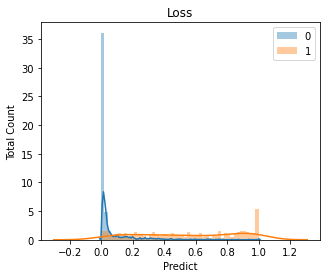

In [176]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5, 4))
for i in [0,1]:
  sns.distplot(train_xth.loc[train.Label==i], bins=50,kde=True)
ax.set_ylabel('Total Count')
ax.set_title('Loss')
ax.legend('01')

In [205]:
# from the above plot we can choose the threshold to be 0.2 or greater
'''Generate the list for thresholds'''
threshold = []
num = 4000
start=0.2
for i in range(num):
  val= start+0.0001*i
  threshold.append(val)


In [206]:
# generate the list of f1_scores 
from sklearn.metrics import f1_score
f1_scores=[]
for thres in threshold:
  Predited_label = []
  for elem in test_xth:
    if elem < thres:
      Predited_label.append(0)
    else:
      Predited_label.append(1)
  f1s=f1_score(test_yth, Predited_label, zero_division=0)
  f1_scores.append(f1s)

In [212]:
# get the corrodinate of the largest f1_score
y=max(f1_scores)
max_index = f1_scores.index(max(f1_scores))
x=threshold[max_index]

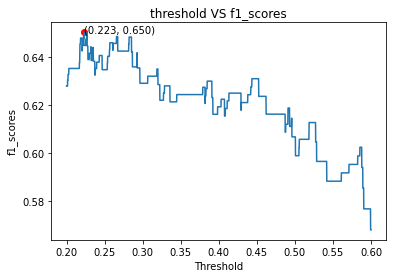

In [217]:
plt.plot(threshold,f1_scores)
plt.title('threshold VS f1_scores')
plt.scatter(x, y, c='red')
plt.xlabel('Threshold')
plt.ylabel('f1_scores')
plt.text(x, y, '({:5.3f}, {:5.3f})'.format(x, y))
plt.show()

In [222]:
print(f'The best f1_scores is{y: 5.4f} for threshold is{x: 5.4f}')

The best f1_scores is 0.6504 for threshold is 0.2225
